In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten


In [2]:
image_size = 32
batch_size = 4 #размер 

Функция для загрузки данных. Проходит по всем папкам в директории, где каждая папка представляет отдельный класс (кошки или собаки).  
Загружает изображения, ресайзит их до 32x32 и нормализует.  
Возвращает массивы изображений (images) и меток (labels).  

In [3]:
def load_data(directory, image_size):
    images = []
    labels = []
    for idx, label_dir in enumerate(os.listdir(directory)):
        if os.path.isdir(os.path.join(directory, label_dir)):
            label = idx #назначаем метку (0 — первая папка, 1 — вторая папка)
            for img in os.listdir(os.path.join(directory, label_dir)):
                img_path = os.path.join(directory, label_dir, img)
                if os.path.isfile(img_path):
                    image = tf.io.read_file(img_path)
                    image = tf.image.decode_jpeg(image, channels=3)
                    image = tf.image.resize(image, [image_size, image_size])
                    image /= 255.0
                    images.append(image)
                    labels.append(label)
    return np.array(images), np.array(labels)


In [4]:
images, labels = load_data(r"data\dogs_cats", image_size=image_size)


(array([1106.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2105.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

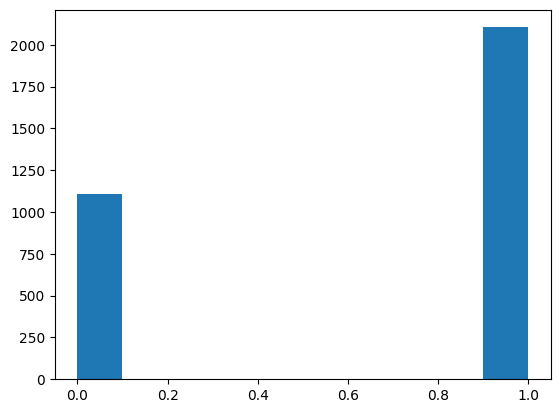

In [5]:
plt.hist(labels) 

Разделяем данные для обучения (80%) и тестирования (20%).  
Создаем датасеты и перемешиваем данные.  

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)


In [7]:
del images
del labels

Тестовый набор данных

In [8]:
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

Используем модель VGG16 и настраиваем.

In [ ]:
from tensorflow.keras.layers import Input

def create_model():
    inputs = Input(shape=(image_size, image_size, 3))
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  #бинарная классификация
                  metrics=['accuracy'])
    return model



Обучение модели, считаем f1-метрику.

In [10]:
def train_and_evaluate(train_images, train_labels, test_ds, epochs=10):
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(train_images)).batch(batch_size)
    model = create_model()
    model.fit(train_ds, epochs=2, validation_data=test_ds)
    y_pred = model.predict(test_images)
    y_pred_classes = (y_pred > 0.5).astype(int)
    return f1_score(test_labels, y_pred_classes, average='macro')

In [ ]:

#обучение на всем обучающем наборе
f1_full = train_and_evaluate(train_images, train_labels, test_ds)
print(f"F1-метрика (весь набор данных): {f1_full:.4f}")

#обучение на 1%, 10%, 20% обучающего набора
percentages = [0.01, 0.1, 0.2]
results = {p: [] for p in percentages}

#проход по процентам данных
for p in percentages:
    for _ in range(5):  
        print(f"{p} and {_}")
        sample_size = int(len(train_images) * p)
        indices = random.sample(range(len(train_images)), sample_size)
        train_images_sample = train_images[indices]
        train_labels_sample = train_labels[indices]

        f1 = train_and_evaluate(train_images_sample, train_labels_sample, test_ds)
        results[p].append(f1)

for p, scores in results.items():
    mean_f1 = np.mean(scores)
    print(f"F1-метрика ({int(p * 100)}% данных, средняя): {mean_f1:.4f}")


Epoch 1/2
642/642 ━━━━━━━━━━━━━━━━━━━━ 89s 134ms/step - accuracy: 0.6235 - loss: 0.7736 - val_accuracy: 0.6563 - val_loss: 0.6432
Epoch 2/2
642/642 ━━━━━━━━━━━━━━━━━━━━ 81s 126ms/step - accuracy: 0.6525 - loss: 0.6567 - val_accuracy: 0.6563 - val_loss: 0.6437
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
F1-метрика (весь набор данных): 0.3962
0.01 and 0
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - accuracy: 0.4303 - loss: 1.1835 - val_accuracy: 0.5194 - val_loss: 0.6899
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 721ms/step - accuracy: 0.6521 - loss: 0.6886 - val_accuracy: 0.3437 - val_loss: 0.7608
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
0.01 and 1
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 785ms/step - accuracy: 0.7994 - loss: 11.9700 - val_accuracy: 0.6563 - val_loss: 0.6871
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step - accuracy: 0.7707 - loss: 0.5905 - val_accuracy: 0.6563 - val_loss: 0.7919
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
0.01 and 2
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 750ms/ste

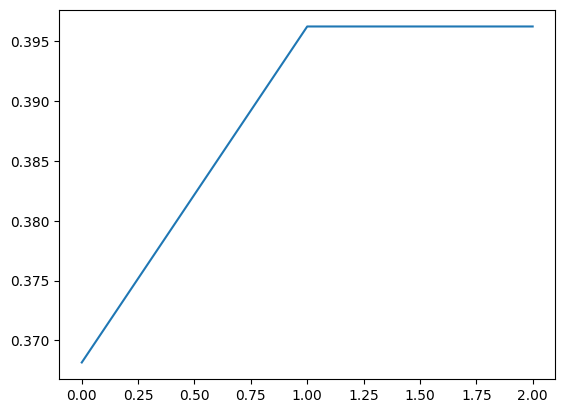

In [12]:
import matplotlib.pyplot as plt
plt.plot([np.mean(x) for x  in results.values()])

In [ ]:
from sklearn.cluster import KMeans

# 1. Least Confidence (LC)
def least_confidence_selection(model, unlabeled_data, n_samples):
    predictions = model.predict(unlabeled_data)
    uncertainties = 1 - np.max(predictions, axis=1)  
    uncertain_indices = np.argsort(uncertainties)[-n_samples:]  
    return uncertain_indices

# 2. Cluster Margin
def cluster_margin_selection(embeddings, n_samples):
    kmeans = KMeans(n_clusters=n_samples, random_state=42)
    kmeans.fit(embeddings)
    closest_indices = []
    for center in kmeans.cluster_centers_:
        distances = np.linalg.norm(embeddings - center, axis=1)
        closest_indices.append(np.argmin(distances))
    return closest_indices

# 3. MNLP
def mnlp_selection(model, unlabeled_data, n_samples):
    predictions = model.predict(unlabeled_data)
    log_probs = np.log(predictions + 1e-10)
    normalized_log_probs = log_probs / np.linalg.norm(log_probs, axis=1, keepdims=True)
    scores = np.sum(normalized_log_probs, axis=1)
    mnlp_indices = np.argsort(scores)[-n_samples:]
    return mnlp_indices

# 4. Bald
def bald_selection(model, unlabeled_data, n_samples, num_mc_samples=10):
    
    f_model = tf.keras.models.Model(inputs=model.input, outputs=model.output)
    f_model.trainable = False

    
    mc_predictions = np.stack([
        f_model.predict(unlabeled_data, batch_size=batch_size, verbose=0)
        for _ in range(num_mc_samples)
    ])

    
    mean_prob = mc_predictions.mean(axis=0)
    entropy = -np.sum(mean_prob * np.log(mean_prob + 1e-10), axis=1)

    
    mc_entropy = -np.sum(mc_predictions * np.log(mc_predictions + 1e-10), axis=2)
    mean_mc_entropy = mc_entropy.mean(axis=0)
    bald_score = entropy - mean_mc_entropy  

    
    bald_indices = np.argsort(bald_score)[-n_samples:]
    return bald_indices


0.01 and 0
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 702ms/step - accuracy: 0.7508 - loss: 49.2764 - val_accuracy: 0.6563 - val_loss: 0.7153
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 691ms/step - accuracy: 0.6453 - loss: 0.7389 - val_accuracy: 0.6563 - val_loss: 1.2102
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step


c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step - accuracy: 0.4605 - loss: 2.6506 - val_accuracy: 0.3437 - val_loss: 0.8535
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step - accuracy: 0.3358 - loss: 0.7841 - val_accuracy: 0.3437 - val_loss: 0.7458
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 701ms/step - accuracy: 0.3868 - loss: 0.9536 - val_accuracy: 0.6563 - val_loss: 0.6819
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 665ms/step - accuracy: 0.6234 - loss: 0.7552 - val_accuracy: 0.3437 - val_loss: 1.5003
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 698ms/step - accuracy: 0.5357 - loss: 19.7101 - val_accuracy: 0.6563 - val_loss: 0.6474
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 686ms/step - accuracy: 0.5778 - loss: 0.8484 - val_accuracy: 0.6439 - val_loss: 0.6887
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
0.01 and 1
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 784ms/step - accuracy: 0.4696 - loss: 1.0905 - val_accuracy: 0.6516 - val_loss: 0.6887
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.5826 - loss: 0.7350 - val_accuracy: 0.6563 - val_loss: 0.6609
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - accuracy: 0.8042 - loss: 424.1263 - val_accuracy: 0.6563 - val_loss: 0.7204
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - accuracy: 0.8245 - loss: 0.5073 - val_accuracy: 0.6563 - val_loss: 0.6930
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 693ms/step - accuracy: 0.6653 - loss: 23.2140 - val_accuracy: 0.6563 - val_loss: 0.6737
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 664ms/step - accuracy: 0.6940 - loss: 0.6528 - val_accuracy: 0.6563 - val_loss: 0.6454
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
0.01 and 2
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 781ms/step - accuracy: 0.5030 - loss: 3.6549 - val_accuracy: 0.6563 - val_loss: 0.6777
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 742ms/step - accuracy: 0.5471 - loss: 0.7914 - val_accuracy: 0.6563 - val_loss: 0.7211
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 776ms/step - accuracy: 0.6694 - loss: 10.3545 - val_accuracy: 0.6563 - val_loss: 0.6654
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step - accuracy: 0.6571 - loss: 0.7208 - val_accuracy: 0.6563 - val_loss: 0.6816
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 826ms/step - accuracy: 0.6914 - loss: 0.9594 - val_accuracy: 0.6563 - val_loss: 0.6992
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step - accuracy: 0.6523 - loss: 0.7779 - val_accuracy: 0.6563 - val_loss: 0.6614
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
0.01 and 3
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 792ms/step - accuracy: 0.7245 - loss: 28.4095 - val_accuracy: 0.6563 - val_loss: 0.6555
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step - accuracy: 0.6659 - loss: 0.6136 - val_accuracy: 0.6563 - val_loss: 0.7166
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 782ms/step - accuracy: 0.6627 - loss: 7.7379 - val_accuracy: 0.6563 - val_loss: 1.0072
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 754ms/step - accuracy: 0.7976 - loss: 0.7965 - val_accuracy: 0.6563 - val_loss: 0.6452
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 786ms/step - accuracy: 0.6349 - loss: 0.9740 - val_accuracy: 0.6563 - val_loss: 0.6453
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 744ms/step - accuracy: 0.6523 - loss: 0.6587 - val_accuracy: 0.6563 - val_loss: 0.8237
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
0.01 and 4
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step - accuracy: 0.1308 - loss: 2.4576 - val_accuracy: 0.3437 - val_loss: 0.8248
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 731ms/step - accuracy: 0.4970 - loss: 0.7502 - val_accuracy: 0.6563 - val_loss: 0.6757
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 786ms/step - accuracy: 0.5068 - loss: 7.3591 - val_accuracy: 0.3437 - val_loss: 0.9186
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 750ms/step - accuracy: 0.4701 - loss: 0.7428 - val_accuracy: 0.6563 - val_loss: 1.4673
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 760ms/step - accuracy: 0.5920 - loss: 1.0823 - val_accuracy: 0.6563 - val_loss: 0.9498
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step - accuracy: 0.7549 - loss: 0.5815 - val_accuracy: 0.4526 - val_loss: 0.6971
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
0.1 and 0
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.5249 - loss: 1.3434 - val_accuracy: 0.6563 - val_loss: 0.7888
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.6984 - loss: 0.6809 - val_accuracy: 0.6563 - val_loss: 0.6565
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.5269 - loss: 1.9429 - val_accuracy: 0.6563 - val_loss: 0.6430
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.5685 - loss: 0.7062 - val_accuracy: 0.6563 - val_loss: 0.6807
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.5376 - loss: 1.1506 - val_accuracy: 0.3437 - val_loss: 0.7221
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.5281 - loss: 0.7225 - val_accuracy: 0.6563 - val_loss: 0.6682
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
0.1 and 1
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
Epoch 1/2
64/64 ━━━━━━

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.7439 - loss: 0.9752 - val_accuracy: 0.6563 - val_loss: 0.6440
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.7014 - loss: 0.6238 - val_accuracy: 0.6563 - val_loss: 0.6673
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.5871 - loss: 1.1508 - val_accuracy: 0.6563 - val_loss: 0.6515
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.6468 - loss: 0.6730 - val_accuracy: 0.6563 - val_loss: 0.6441
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.5924 - loss: 2.3040 - val_accuracy: 0.6563 - val_loss: 0.6747
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.5595 - loss: 0.6865 - val_accuracy: 0.6563 - val_loss: 0.6603
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
0.1 and 2
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
Epoch 1/2
64/64 ━━━━━━

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.7011 - loss: 2.0504 - val_accuracy: 0.6563 - val_loss: 0.6751
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.7480 - loss: 0.5811 - val_accuracy: 0.6563 - val_loss: 0.6652
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.5331 - loss: 0.9790 - val_accuracy: 0.6563 - val_loss: 0.6463
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.6600 - loss: 0.6614 - val_accuracy: 0.6563 - val_loss: 0.6688
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.5433 - loss: 1.1674 - val_accuracy: 0.6470 - val_loss: 0.6656
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.6002 - loss: 0.7043 - val_accuracy: 0.6563 - val_loss: 0.6419
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
0.1 and 3
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
Epoch 1/2
64/64 ━━━━━━

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.6575 - loss: 1.9331 - val_accuracy: 0.6563 - val_loss: 0.6513
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.7054 - loss: 0.6303 - val_accuracy: 0.6563 - val_loss: 0.6434
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.5378 - loss: 4.3892 - val_accuracy: 0.6563 - val_loss: 0.6454
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.5697 - loss: 0.6861 - val_accuracy: 0.3437 - val_loss: 0.7257
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.5965 - loss: 1.6500 - val_accuracy: 0.6563 - val_loss: 0.6492
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.6106 - loss: 0.6859 - val_accuracy: 0.4635 - val_loss: 0.6956
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
0.1 and 4
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step
Epoch 1/2
64/64 ━━━━━━

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.6531 - loss: 0.7615 - val_accuracy: 0.6563 - val_loss: 0.6836
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.7215 - loss: 0.6176 - val_accuracy: 0.6563 - val_loss: 0.6523
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.6187 - loss: 114.9063 - val_accuracy: 0.6563 - val_loss: 0.6797
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.6193 - loss: 0.7117 - val_accuracy: 0.6563 - val_loss: 0.6649
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.5696 - loss: 0.8375 - val_accuracy: 0.6563 - val_loss: 0.6426
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.5922 - loss: 0.7466 - val_accuracy: 0.6563 - val_loss: 0.6583
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
0.2 and 0
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
Epoch 1/2
129/129 ━━

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.7255 - loss: 0.9591 - val_accuracy: 0.6563 - val_loss: 0.6616
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.7357 - loss: 0.5940 - val_accuracy: 0.6563 - val_loss: 0.6439
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.5980 - loss: 1.2731 - val_accuracy: 0.6563 - val_loss: 0.6435
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.6223 - loss: 0.6627 - val_accuracy: 0.6563 - val_loss: 0.7316
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.6268 - loss: 0.9758 - val_accuracy: 0.6563 - val_loss: 0.6436
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.6752 - loss: 0.6439 - val_accuracy: 0.6563 - val_loss: 0.6706
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
0.2 and 1
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step
Epoch 1/2


c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.6881 - loss: 1.1140 - val_accuracy: 0.6563 - val_loss: 0.6617
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.7061 - loss: 0.6116 - val_accuracy: 0.6563 - val_loss: 0.6605
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.5881 - loss: 0.9328 - val_accuracy: 0.6563 - val_loss: 0.6441
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.5706 - loss: 0.6809 - val_accuracy: 0.6563 - val_loss: 0.6536
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.6290 - loss: 56.8229 - val_accuracy: 0.6563 - val_loss: 0.8930
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.5909 - loss: 0.7357 - val_accuracy: 0.6563 - val_loss: 0.6460
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
0.2 and 2
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step
Epoch 1/2

c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.6236 - loss: 1.4084 - val_accuracy: 0.6563 - val_loss: 0.6956
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.6885 - loss: 0.6608 - val_accuracy: 0.6563 - val_loss: 0.6623
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.6278 - loss: 0.7962 - val_accuracy: 0.6563 - val_loss: 0.6522
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.6093 - loss: 0.6865 - val_accuracy: 0.6563 - val_loss: 1.6148
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.5712 - loss: 4.1712 - val_accuracy: 0.6563 - val_loss: 0.6518
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.6394 - loss: 0.6582 - val_accuracy: 0.6563 - val_loss: 0.6563
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
0.2 and 3
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step
Epoch 1/2


c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.7224 - loss: 0.8384 - val_accuracy: 0.6563 - val_loss: 0.6585
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.7137 - loss: 0.6095 - val_accuracy: 0.6563 - val_loss: 0.6439
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.5944 - loss: 0.8971 - val_accuracy: 0.6563 - val_loss: 0.6441
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.6500 - loss: 0.6613 - val_accuracy: 0.3328 - val_loss: 0.7173
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.6125 - loss: 0.7165 - val_accuracy: 0.6563 - val_loss: 0.6457
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.6272 - loss: 0.7098 - val_accuracy: 0.6563 - val_loss: 0.6475
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
0.2 and 4
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step
Epoch 1/2


c:\Users\Kravt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.6461 - loss: 1.0161 - val_accuracy: 0.6563 - val_loss: 0.6588
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.6666 - loss: 0.6501 - val_accuracy: 0.6563 - val_loss: 0.6489
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.6484 - loss: 0.8516 - val_accuracy: 0.6563 - val_loss: 0.6524
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.7010 - loss: 0.6281 - val_accuracy: 0.6563 - val_loss: 0.6837
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step
Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.6411 - loss: 3.5108 - val_accuracy: 0.6563 - val_loss: 0.6538
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.6354 - loss: 0.6667 - val_accuracy: 0.6563 - val_loss: 0.6546
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
F1-метрика (1% данных, LC, средняя): 0.3682
F1-метрика (1% д

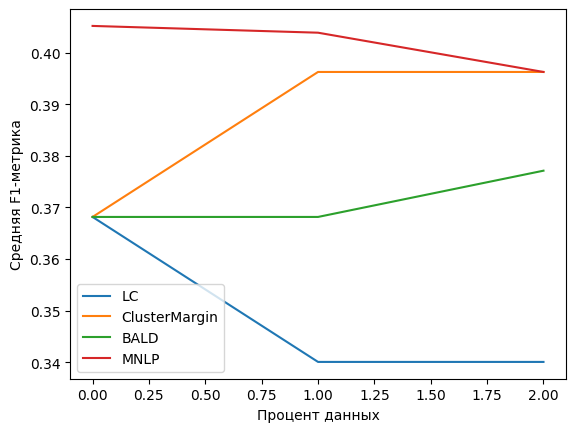

In [ ]:
#новый блок для активного обучения
active_learning_results = {p: {"LC": [], "ClusterMargin": [], "BALD": [], "MNLP": []} for p in percentages}

for p in percentages:
    for _ in range(5):  
        sample_size = int(len(train_images) * p)
        unlabeled_data = train_images.copy()
        print(f"{p} and {_}")
        #создаем новую модель для каждой итерации
        model = create_model()

        # Least Confidence
        lc_indices = least_confidence_selection(model, unlabeled_data, sample_size)
        lc_images = unlabeled_data[lc_indices]
        lc_labels = train_labels[lc_indices]
        f1_lc = train_and_evaluate(lc_images, lc_labels, test_ds)
        active_learning_results[p]["LC"].append(f1_lc)

        # Cluster Margin
        embeddings_model = models.Model(inputs=model.input, outputs=model.layers[-2].output)
        embeddings = embeddings_model.predict(unlabeled_data)
        cm_indices = cluster_margin_selection(embeddings, sample_size)
        cm_images = unlabeled_data[cm_indices]
        cm_labels = train_labels[cm_indices]
        f1_cm = train_and_evaluate(cm_images, cm_labels, test_ds)
        active_learning_results[p]["ClusterMargin"].append(f1_cm)

        # BALD
        bald_indices = bald_selection(model, unlabeled_data, sample_size)
        bald_images = unlabeled_data[bald_indices]
        bald_labels = train_labels[bald_indices]
        f1_bald = train_and_evaluate(bald_images, bald_labels, test_ds)
        active_learning_results[p]["BALD"].append(f1_bald)

        # Maximum Normalized Log-Probability
        mnlp_indices = mnlp_selection(model, unlabeled_data, sample_size)
        mnlp_images = unlabeled_data[mnlp_indices]
        mnlp_labels = train_labels[mnlp_indices]
        f1_mnlp = train_and_evaluate(mnlp_images, mnlp_labels, test_ds)
        active_learning_results[p]["MNLP"].append(f1_mnlp)

#вывод результатов
for p, strategies in active_learning_results.items():
    for strategy_name, scores in strategies.items():
        mean_f1 = np.mean(scores)
        print(f"F1-метрика ({int(p * 100)}% данных, {strategy_name}, средняя): {mean_f1:.4f}")

#визуализация
for strategy_name in ["LC", "ClusterMargin", "BALD", "MNLP"]:
    plt.plot([np.mean(active_learning_results[p][strategy_name]) for p in percentages], label=strategy_name)

plt.xlabel("Процент данных")
plt.ylabel("Средняя F1-метрика")
plt.legend()
plt.show()


Вывод на основе результатов:  

На небольшом объеме данных (1%), все методы, кроме MNLP, показывают одинаковую F1-метрику (0.3682). MNLP превосходит остальные методы, достигая значения 0.4052.  

Эффективность методов с увеличением объема данных (10%): MNLP сохраняет свое преимущество, демонстрируя F1-метрику 0.4039. Cluster Margin также показывает улучшение (0.3962). Методы LC и BALD отстают, показывая 0.3401 и 0.3682 соответственно.

Эффективность методов при 20% данных: MNLP и Cluster Margin достигают одинакового результата (0.3962). BALD немного улучшает результаты по сравнению с 10% данных (0.3771). LC не показывает улучшения (0.3401), оставляя этот метод менее эффективным.